In [1]:
library(quantmod)
library(forecast)
library(tseries)
library(rugarch)

Caricamento del pacchetto richiesto: xts

Caricamento del pacchetto richiesto: zoo


Caricamento pacchetto: ‘zoo’


I seguenti oggetti sono mascherati da ‘package:base’:

    as.Date, as.Date.numeric


Caricamento del pacchetto richiesto: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Caricamento del pacchetto richiesto: parallel


Caricamento pacchetto: ‘rugarch’


Il seguente oggetto è mascherato da ‘package:stats’:

    sigma




In [17]:
#preprocessing
getSymbols("SPY", src = "yahoo", from = "2010-01-01", to = Sys.Date())
spy_prices <- Cl(SPY)
log_prices <- log(spy_prices)
diff_log_prices <- diff(log_prices)#*100#to avoid optimizer issues
diff_log_prices <- na.omit(diff_log_prices)

[1] "SPY"

### Analisi esplorativa
Come prima cosa è opportuno plottare la serie temporale dei prezzi e il logaritmo dei prezzi. Inoltre è utile plottare la serie differenziata del logaritmo dei prezzi, su cui verificheremo l'ipotesi di stazionarietà debole. Come ultimo plot poi verificheremo l'aderenza della distribuzione dei prezzi logaritmici differenziati alla normale


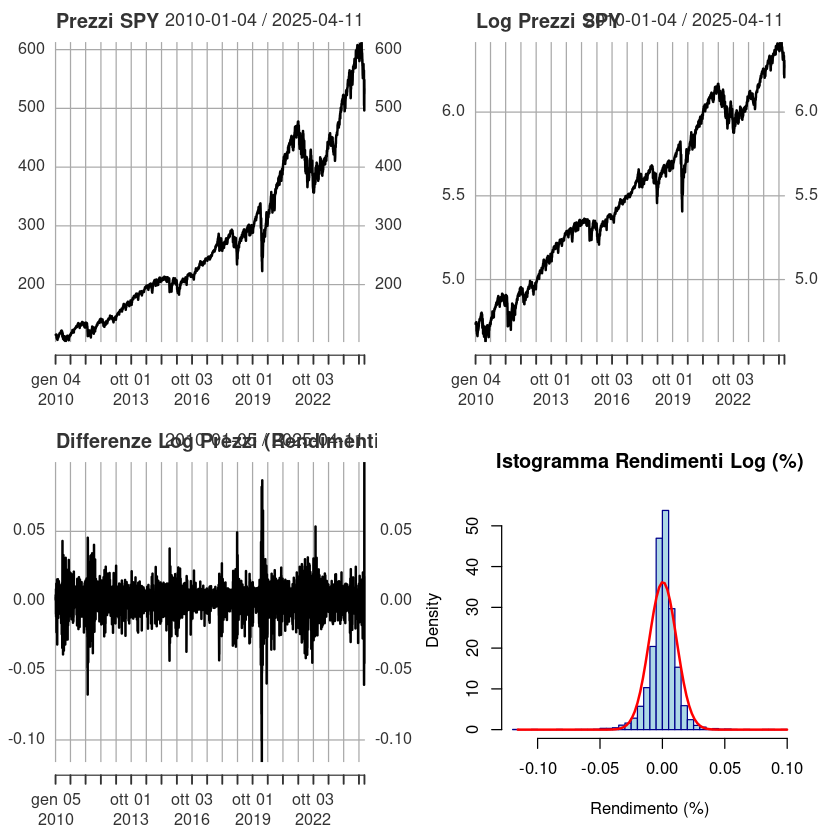

In [18]:
par(mfrow = c(2,2))
plot(spy_prices, main = "Prezzi SPY")
plot(log_prices, main = "Log Prezzi SPY")
plot(diff_log_prices, main = "Differenze Log Prezzi (Rendimenti, in %)")
diff_log_prices_num <- as.numeric(diff_log_prices)
hist(diff_log_prices_num, breaks = 50, probability = TRUE,
     main = "Istogramma Rendimenti Log (%)", 
     xlab = "Rendimento (%)", col = "lightblue", border = "darkblue")
x_vals <- seq(from = min(diff_log_prices_num), to = max(diff_log_prices_num), length.out = 100)
dens_vals <- dnorm(x_vals, mean = mean(diff_log_prices_num), sd = sd(diff_log_prices_num))
lines(x_vals, dens_vals, col = "red", lwd = 2)
par(mfrow = c(1,1))

### Verifica della stazionarietà (debole) della serie
Utilizzando l'Augmented Dickey-Fuller test, che suppone la non stazionarietà come ipotesi nulla possiamo capire se la serie è stazionaria in senso debole, condizione necessaria per l'applicazione di qualsiasi modello arima.

In [19]:
adf_result <- adf.test(diff_log_prices)
print(adf_result)

Warning message in adf.test(diff_log_prices):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_log_prices
Dickey-Fuller = -16.338, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



Come ci aspettavamo la serie è debolmente stazionaria. Questo permette di poter trovare un modello arima per stimare la parte di medie e valutarne la parte di residui. Come prima cosa andiamo a plottare ACF e PACF per i rendimenti differenziati, che possono suggerire informazioni sugli ordini di AR e MA.

#### ACF
Misura la correlazione tra una serie temporale e se stessa spostata di un lag. Indica quanto è forte la correlazione tra $X_t$ e $X_{t-k}$. Quando l'ACF si azzera, la correlazione si annulla e questo suggerisce l'ordine della componente MA del modello.

#### PACF
Misura la correlazione diretta tra la serie e le sue versioni ritardate al lag $k$, controllando l'effetto dei lag intermenti. Fornisce l'autocorrelazione tra $X_t$ e $X_{t-k}$ quando si tengono costanti i restanti valori. Questo è particolarmente utile per determinare l'ordine della componente AR in un modello arima.


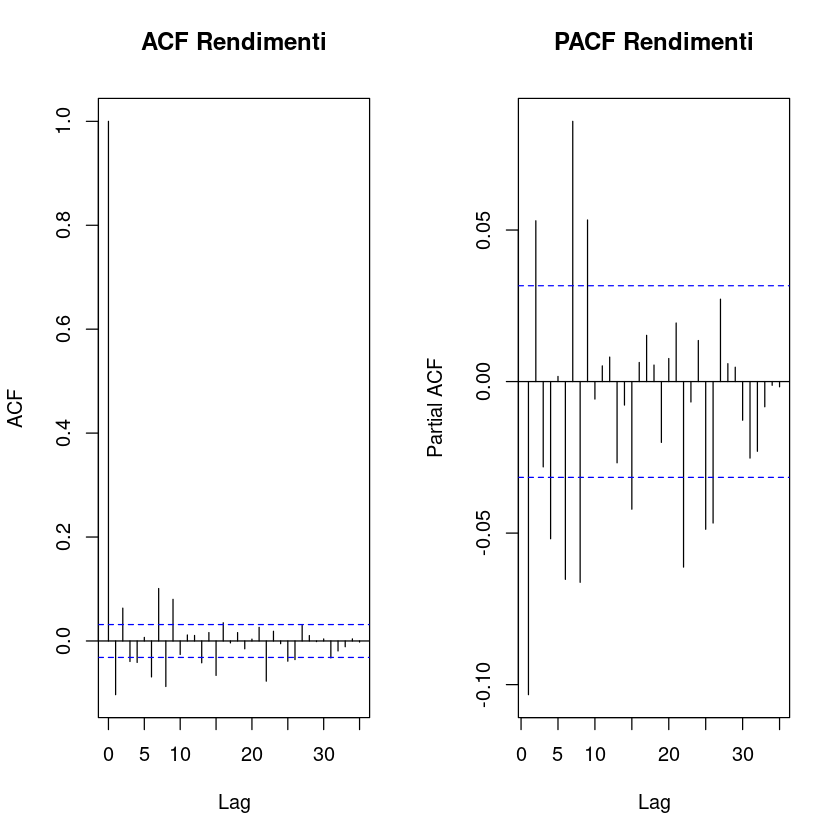

In [20]:
par(mfrow = c(1,2))
acf(diff_log_prices, main = "ACF Rendimenti")
pacf(diff_log_prices, main = "PACF Rendimenti")
par(mfrow = c(1,1))

Possiamo ora stimare i modelli ARIMA. Utilizzeremo per la ricerca modelli con $ p,q \leq 2$ per evitare overfitting e rendere l'interpretazione piu chiara. Questo ci permette di confrontare direttamente i modelli tramite criteri informativi come l'AIC, oltre ad ottenere una stima più stabile dei parametri.

In [ ]:
#model named with 1 as integrating param due to preprocess
model_111 <- arima(diff_log_prices, order = c(1,0,1))
model_211 <- arima(diff_log_prices, order = c(2,0,1))
model_121 <- arima(diff_log_prices, order = c(1,0,2))
model_212 <- arima(diff_log_prices, order = c(2,0,2))
model_011 <- arima(diff_log_prices, order = c(0,0,1))
model_100 <- arima(diff_log_prices, order = c(1,0,0))
#aic index
cat("AIC modello ARIMA(1,1,1):", AIC(model_111), "\n")
cat("AIC modello ARIMA(2,1,1):", AIC(model_211), "\n")
cat("AIC modello ARIMA(1,1,2):", AIC(model_121), "\n")
cat("AIC modello ARIMA(2,1,2):", AIC(model_212), "\n")
cat("AIC modello ARIMA(0,1,1):", AIC(model_011), "\n")


AIC modello ARIMA(1,1,1): -23783.52 
AIC modello ARIMA(2,1,1): -23783.73 
AIC modello ARIMA(1,1,2): -23784.38 
AIC modello ARIMA(2,1,2): -23856.29 
AIC modello ARIMA(0,1,1): -23771.64 


Possiamo notare come il modello ARIMA(2,1,2) abbia AIC più basso e quindi sia il migliore per modellizzare la parte di media della nostra serie temporale. Siamo interessati ora a visualizzare i residui.

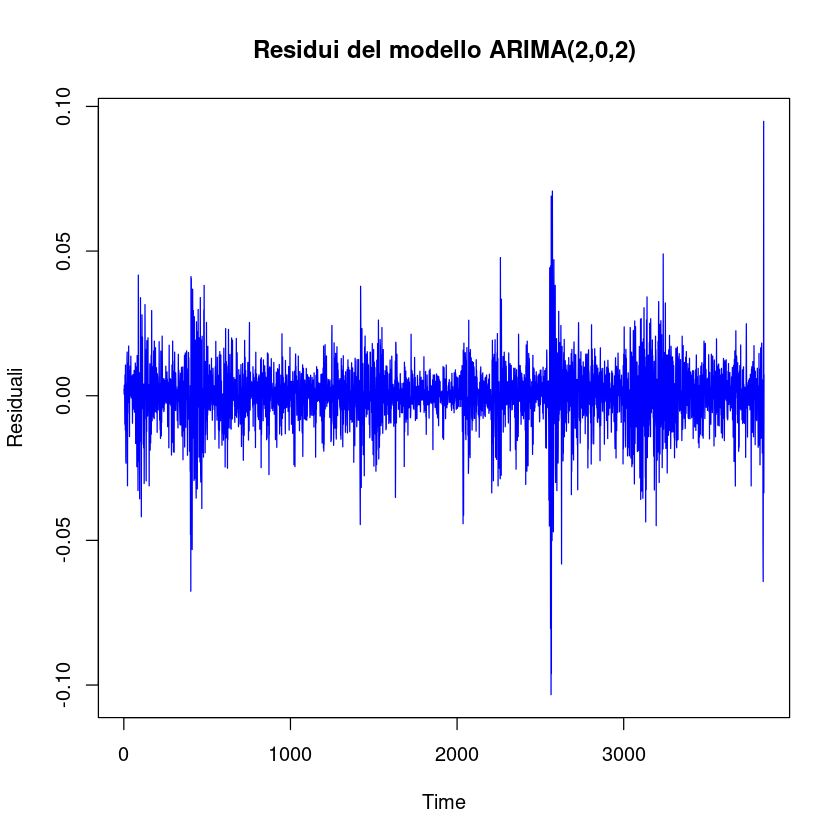

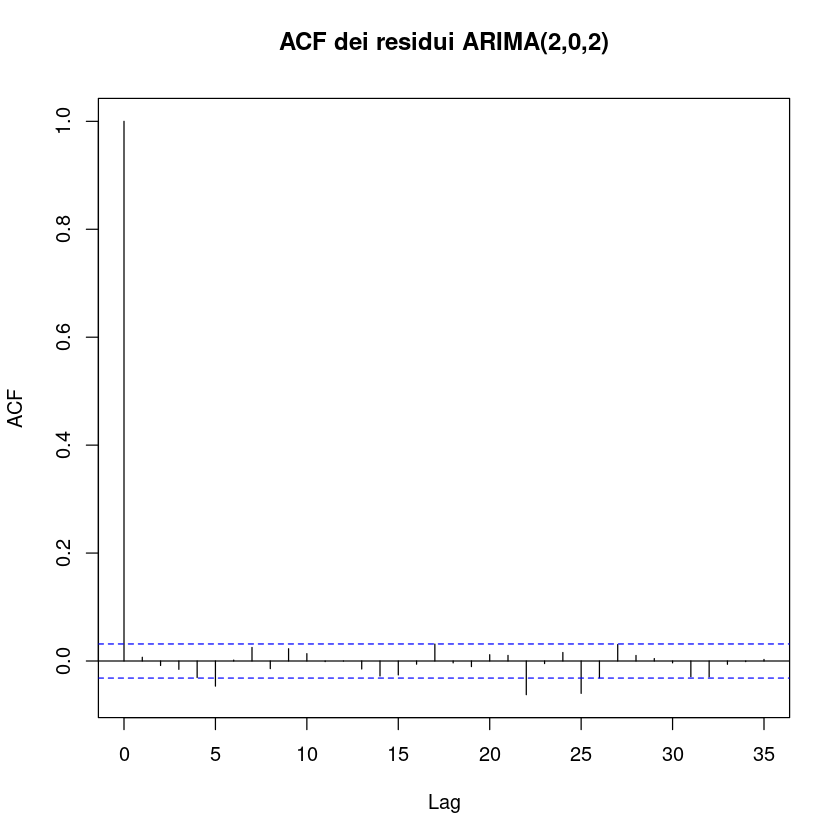

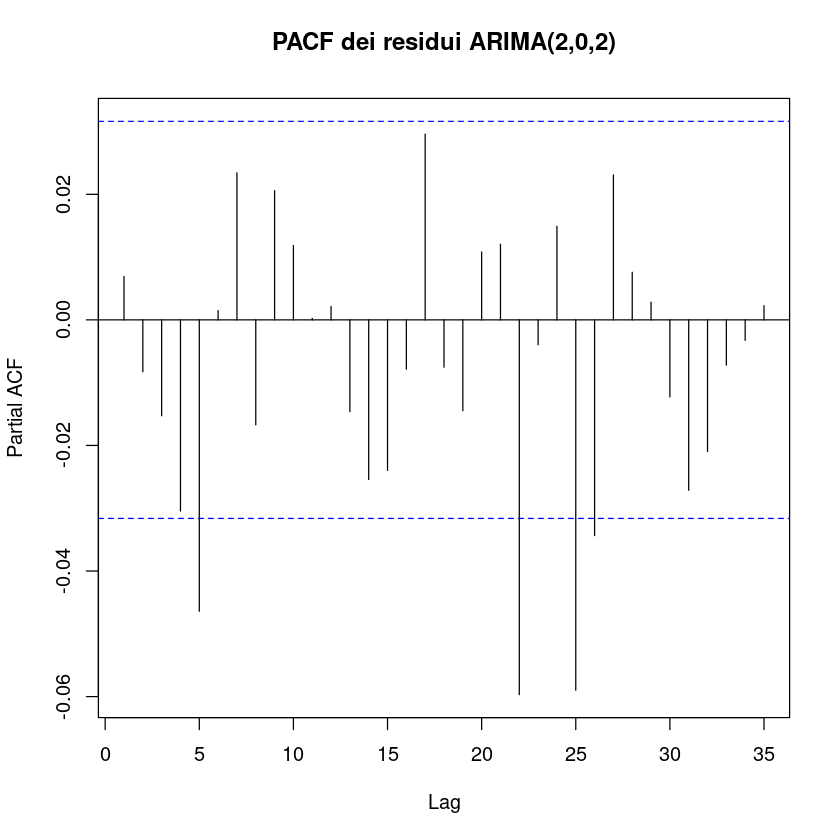

In [26]:
res_212 <- residuals(model_212)
#plot
plot(res_212, 
     main = "Residui del modello ARIMA(2,0,2)", 
     ylab = "Residuali", 
     col = "blue")
acf(res_212, 
    main = "ACF dei residui ARIMA(2,0,2)")   

pacf(res_212, 
     main = "PACF dei residui ARIMA(2,0,2)") 


Possiamo ora utilizzare il test Ljung-Box per verificare se i residui del modello mostrano autocorrelazioni significative fino ad un certo numero di lag. Il test confronta le autocorrelazioni osservate nei residui con quelle attese per una serie casuale. Questo permette di valutare eventuali effetti di clustering della volatilità per cui sarebbe ragionevole utilizzare un modello ARCH/GARCH.

In [27]:
#test on residuals
lb_test <- Box.test(res_212, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui:\n")
print(lb_test)
#test on square residuals for ARCH/GARCH
lb_test_sq <- Box.test(res_212^2, lag = 20, type = "Ljung-Box")
cat("Ljung-Box test sui residui^2 (per effetti ARCH):\n")
print(lb_test_sq)

Ljung-Box test sui residui:

	Box-Ljung test

data:  res_212
X-squared = 30.417, df = 20, p-value = 0.06338

Ljung-Box test sui residui^2 (per effetti ARCH):

	Box-Ljung test

data:  res_212^2
X-squared = 3302.5, df = 20, p-value < 2.2e-16



I p-value bassi confermando l'idea iniziale : il p-value sui residui standard non permette di rifiutare l'ipotesi nulla, ovvero globalmente i residui non mostrano autocorrelazione significativa. La parte ARIMA ha dunque catturato in maniera efficace la struttura media della serie.
Tuttavia questo test valuta solo la parte lineare della serie e non la struttura della volatilità che viene efficacemente catturata dal secondo test effettuato, ovvero quello dei residui al quadrato. Infatti nel test dei residui al quadrato dobbiamo rifiutare l'ipotesi nulla, ammettendo l'esistenza di una forte correlazione. Questo è un segnale tipico di clustering della volatilità che motiva la necessità di implementare una componente ARCH/GARCH per modellizzare la varianza in modo condizionale.